In [1]:
import geopandas as gpd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import os
import rioxarray

from levee_hunter.utils import find_splits, interactive_labeling
from levee_hunter.get_mask import get_mask
from levee_hunter.segmentation_dataset import SegmentationDataset
from levee_hunter.plots import plot_img_and_target


from torch.utils.data import DataLoader
import albumentations as A
import segmentation_models_pytorch as smp
from levee_hunter.plots import infer_and_visualize
import torch
import torch.nn as nn
import torch.optim as optim

/Users/pawel/miniforge3/envs/Fathom/lib/python3.11/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/Users/pawel/miniforge3/envs/Fathom/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/pawel/miniforge3/envs/Fathom/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /Users/pawel/miniforge3/envs/Fathom/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/Users/pawel/miniforge3/envs/Fathom/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/pawel/miniforge3/envs/Fathom/lib/python3.11/site-packages/torchvision/../..

In [2]:
# Importing the Lidar data (.tif files)
data_dir = "../data/raw/w3-Lidar"
data_dir2 = "../data/raw/w4-Lidar/1m_resolution"
tif_files = [file for file in os.listdir(data_dir) if file.endswith(".tif")]
tif_files2 = [file for file in os.listdir(data_dir2) if file.endswith(".tif")]

images = [
    rioxarray.open_rasterio(os.path.join(data_dir2, file)) for file in tif_files2[:]
]

images = images + [rioxarray.open_rasterio(os.path.join(data_dir, tif_files[2]))]

len(images)

7

In [3]:
# val_img = images[6]  # last one for validation


# This way we can validate while showing levees which have not been seen partially:
# If we have eg two images along the same levee, and one of those images goes to training
# and the other to validation, then it is not precise as this is still the same levee.
# images = images[:6]
# len(images)

# I decided to abandon this idea, as even using seperate image does not guarantee
# the levees are separate, as the large images are from the same area
# Instead a better option might be to use metrics to test on unseen
# validation data as before, but also use bad_dataset with unmarked levees
# to see by eye how it is doing on 100% unseen data (data which is not even in the db)

In [4]:
images[0]

<xarray.DataArray (band: 1, y: 10012, x: 10012)> Size: 401MB
[100240144 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 80kB 6.1e+05 6.1e+05 6.1e+05 ... 6.2e+05 6.2e+05
  * y            (y) float64 80kB 4.24e+06 4.24e+06 ... 4.23e+06 4.23e+06
    spatial_ref  int64 8B 0
Attributes: (12/15)
    AREA_OR_POINT:             Area
    LAYER_TYPE:                athematic
    STATISTICS_MAXIMUM:        9.120623588562
    STATISTICS_MEAN:           0.56785832215484
    STATISTICS_MEDIAN:         0
    STATISTICS_MINIMUM:        -3.8568623065948
    ...                        ...
    STATISTICS_STDDEV:         1.5781120578754
    STATISTICS_VALID_PERCENT:  99.26
    _FillValue:                -3.402823e+38
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 Layer_1

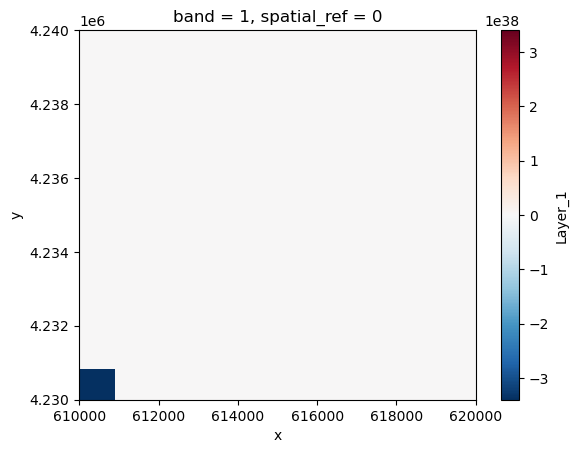

In [5]:
images[0].plot()

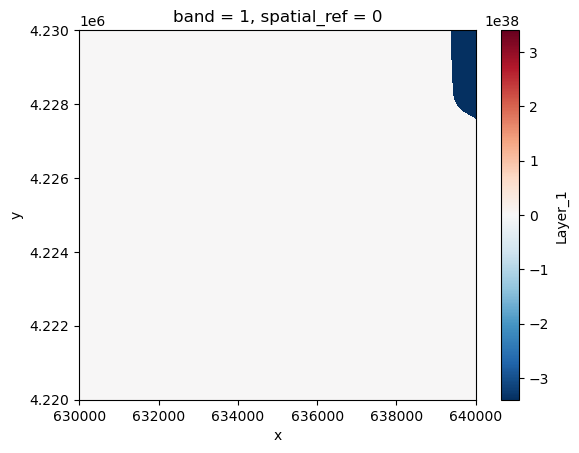

In [6]:
images[2].plot()

In [7]:
np.min(images[0].values), np.max(images[0].values)

(-3.402823e+38, 9.120624)

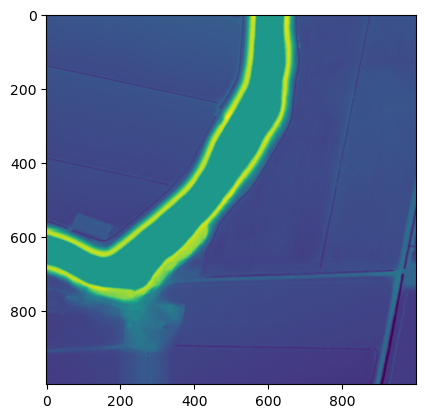

In [8]:
plt.imshow(images[2].values.squeeze()[:1000, :1000])

In [9]:
for img in images:
    print(img.rio.crs)

EPSG:26910
EPSG:26910
EPSG:26910
EPSG:26910
EPSG:26910
EPSG:26910
EPSG:26910


In [10]:
for img in images:
    print(img.shape)

(1, 10012, 10012)
(1, 10012, 10012)
(1, 10012, 10012)
(1, 10012, 10012)
(1, 10012, 10012)
(1, 10012, 10012)
(1, 10012, 10012)


In [11]:
# Load the levees data
levees_file = "../data/raw/w1-Kickoff/us_levees_n38w122.gpkg"
levees_data = gpd.read_file(levees_file)
levees_data_26910 = levees_data.to_crs("EPSG:26910")

In [12]:
levees_file = "../data/raw/w3-Levees/levees.gpkg"
levees_data = gpd.read_file(levees_file)
levees_data_26910_full = levees_data.to_crs("EPSG:26910")

/Users/pawel/miniforge3/envs/Fathom/lib/python3.11/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'levees.gpkg': 'System' (default), 'AlignmentLine'. Specify layer parameter to avoid this warning.
  result = read_func(


In [13]:
levees_data_26910

,states,floodplainManagement,districtNames,lon,leveeLengthInMiles,lat,location,leveedAreaSquareMiles,communitiesBreakdown,yearConstructed,name,geometry
0,California,FEMA Region 9,Sacramento,W122,8.867156,N38,"Oakley, Contra Costa County, California",4.624417,"Contra Costa County, CA; Oakley city, CA",NaN,Contra Costa County Levee 22,"LINESTRING Z (617775.399 4205614.617 13.096, 6..."
1,California,FEMA Region 9,Sacramento,W122,2.942670,N38,"Oakley, Contra Costa County, California",0.406329,"Oakley city, CA",NaN,Contra Costa County Levee 24,"LINESTRING Z (616877.08 4206152.44 0.0001, 616..."
2,California,FEMA Region 9,Sacramento,W122,0.166895,N38,"Pittsburg, Contra Costa County, California",0.007525,"Pittsburg city, CA",NaN,Contra Costa County Levee 217,"LINESTRING Z (601470.47 4209106.432 0.0001, 60..."
3,California,FEMA Region 9,Sacramento,W122,0.292736,N38,"Pittsburg, Contra Costa County, California",0.024989,"Pittsburg city, CA",NaN,Contra Costa County Levee 55,"LINESTRING Z (601429.824 4209117.08 0.0001, 60..."
4,California,FEMA Region 9,Sacramento,W122,4.587647,N38,"Pittsburg, Contra Costa County, California",0.650581,"Contra Costa County, CA",NaN,Contra Costa County Levee 198,"LINESTRING Z (601545.652 4209650.991 0.0001, 6..."
...,...,...,...,...,...,...,...,...,...,...,...,...
225,California,FEMA Region 9,Sacramento,W122,3.701904,N38,"Roseville, Sutter County, California",0.796572,"Sutter County, CA",NaN,Sutter County Levee System 2494,"LINESTRING Z (630035.289 4296018.217 45.796, 6..."
226,California,FEMA Region 9,Sacramento,W122,1.784802,N38,"Lodi, San Joaquin County, California",0.039312,"Lodi city, CA",NaN,San Joaquin County Levee System 2507,"LINESTRING Z (650467.157 4223708.15 54.734, 65..."
227,California,FEMA Region 9,Sacramento,W122,3.294935,N38,"Linden, San Joaquin County, California",0.648053,"San Joaquin County, CA",NaN,San Joaquin County Levee System 2576,"LINESTRING Z (671196.111 4209203.372 109.984, ..."
228,California,FEMA Region 9,Sacramento,W122,3.084150,N38,"Stockton, San Joaquin County, California",0.476652,None,NaN,Atlas Tract Dry Land Levee,"LINESTRING Z (642956.521 4211836.734 5.6, 6429..."


In [14]:
levees_data_26910_full

,name,floodOfRecordFlow,floodOfRecordDate,closureStructureMiles,closureStructureCount,leveeLengthInMiles,floodwallLengthInMiles,location,waterway,sponsors,...,responsibleOrgName,authorizationCategoryName,sponsorTypes,sponsorRoles,swifValue,hasActiveScreening,yearConstructed,evacuationPlan,systemId,geometry
0,Lawyers Creek LB,NaN,None,NaN,NaN,1.623282,NaN,"Kamiah, Lewis County, Idaho",Lawyers Creek,"City of Kamiah, ID, Idaho County, ID, Lewis Co...",...,USACE - Walla Walla District,"USACE Federally Authorized, Operated & Maintai...",County Government ;Municipal Government,"Owner, maintainer & operator;Owner, maintainer...",None,1.0,1960.0,None,6005000705,"LINESTRING Z (1036514.697 5141213.21 1294, 103..."
1,NSA Big Creek Levee System,NaN,None,NaN,NaN,2.673795,NaN,"Millington, Shelby County, Tennessee",Big Creek,Naval Support Activity Midsouth,...,Department of the Navy,"USACE Federally Authorized, Operated & Maintai...",Federal Government,Owner / sponsor,None,1.0,1950.0,None,4005000022,"LINESTRING Z (3562136.041 4458773.029 277.669,..."
2,West Point - Elkhorn LB,NaN,None,NaN,NaN,1.941477,NaN,"West Point, Cuming County, Nebraska",Elkhorn River,"City of West Point, UNKNOWN NON-PROJECT SPONSOR",...,USACE - Omaha District,"USACE Federally Authorized, Operated & Maintai...",Municipal Government;Private,"Owner, maintainer & operator;Owner, maintainer...",SWIF Accepted,1.0,1964.0,None,4705000052,"LINESTRING Z (2688322.048 4981165.973 0.0001, ..."
3,Salmon Creek - Left Bank,NaN,None,NaN,NaN,1.174830,NaN,"Oakridge, Lane County, Oregon",Salmon Creek,City of Oakridge,...,USACE - Portland District,"USACE Federally Authorized, Operated & Maintai...",None,Owner / sponsor,None,1.0,NaN,None,5005906201,"LINESTRING Z (544991.771 4843704.734 0, 544963..."
4,Watchman Campground Levee,NaN,None,NaN,NaN,0.336471,NaN,"Springdale, Washington County, Utah",Virgin River,National Park Service,...,National Park Service,Other Federal Agency,Federal Government,Owner / sponsor,None,NaN,NaN,None,7105000007,LINESTRING Z (1389692.863 4164315.042 3915.711...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6664,Beach Lake - Morrison Creek,0.0,None,0.007786,1.0,5.088277,1.630651,"Sacramento, Sacramento County, California",Morrison Creek,"Central Valley Flood Protection Board, City of...",...,USACE - Sacramento District,"USACE Federally Authorized, Operated & Maintai...",Flood Control Agency;Municipal Government;Stat...,"Owner / sponsor;Owner / sponsor;Owner, maintai...",None,NaN,2008.0,None,5205000293,"LINESTRING Z (634557.592 4261484.018 22.73, 63..."
6665,Sacramento River west bank,0.0,None,NaN,NaN,119.722822,NaN,"Meridian, Sutter County, California","Colusa Basin Drainage Canal, Sacramento River","CA Department of Water Resources, Central Vall...",...,USACE - Sacramento District,"USACE Federally Authorized, Operated & Maintai...",Public Utility;Public Utility;State Government...,Inspection;Maintainer & operator;Maintainer & ...,Letter of Intent Approved,1.0,1959.0,None,5205000561,"LINESTRING Z (585566.733 4387388.787 122.968, ..."
6666,"RD 0017, 2094, 2096, 2075, 2064 - SJ River East",0.0,None,NaN,NaN,43.861644,NaN,"Manteca, San Joaquin County, California","French Camp Slough, San Joaquin River, Stanisl...","CA Department of Water Resources, Central Vall...",...,USACE - Sacramento District,"USACE Federally Authorized, Operated & Maintai...",Public Utility;Public Utility;State Government...,Inspection;Maintainer & operator;Owner / spons...,Letter of Intent Approved,1.0,1971.0,None,5205001151,"LINESTRING Z (663288.588 4176691.779 60.407, 6..."
6667,West Sacramento,0.0,None,0.467053,5.0,46.387873,0.120563,"West Sacramento, Yolo County, California","Deep Water Ship Channel, Sacramento Bypass, Sa...","CA Department of Water Resources, Central Vall...",...,USACE - Sacramento District,"USACE Federally Authorized, USACE Operated & M...",Federal Government ;Municipal Government;Publi...,Inspection;Inspection;Maintainer & operator;M

<Axes: >

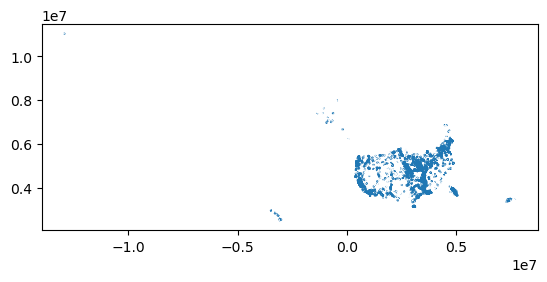

In [15]:
levees_data_26910_full.plot()

In [16]:
levees_data

,name,floodOfRecordFlow,floodOfRecordDate,closureStructureMiles,closureStructureCount,leveeLengthInMiles,floodwallLengthInMiles,location,waterway,sponsors,...,responsibleOrgName,authorizationCategoryName,sponsorTypes,sponsorRoles,swifValue,hasActiveScreening,yearConstructed,evacuationPlan,systemId,geometry
0,Lawyers Creek LB,NaN,None,NaN,NaN,1.623282,NaN,"Kamiah, Lewis County, Idaho",Lawyers Creek,"City of Kamiah, ID, Idaho County, ID, Lewis Co...",...,USACE - Walla Walla District,"USACE Federally Authorized, Operated & Maintai...",County Government ;Municipal Government,"Owner, maintainer & operator;Owner, maintainer...",None,1.0,1960.0,None,6005000705,"LINESTRING Z (-116.04378 46.21238 1293.9998, -..."
1,NSA Big Creek Levee System,NaN,None,NaN,NaN,2.673795,NaN,"Millington, Shelby County, Tennessee",Big Creek,Naval Support Activity Midsouth,...,Department of the Navy,"USACE Federally Authorized, Operated & Maintai...",Federal Government,Owner / sponsor,None,1.0,1950.0,None,4005000022,"LINESTRING Z (-89.85792 35.33613 277.6692, -89..."
2,West Point - Elkhorn LB,NaN,None,NaN,NaN,1.941477,NaN,"West Point, Cuming County, Nebraska",Elkhorn River,"City of West Point, UNKNOWN NON-PROJECT SPONSOR",...,USACE - Omaha District,"USACE Federally Authorized, Operated & Maintai...",Municipal Government;Private,"Owner, maintainer & operator;Owner, maintainer...",SWIF Accepted,1.0,1964.0,None,4705000052,"LINESTRING Z (-96.71256 41.85119 0.00013, -96...."
3,Salmon Creek - Left Bank,NaN,None,NaN,NaN,1.174830,NaN,"Oakridge, Lane County, Oregon",Salmon Creek,City of Oakridge,...,USACE - Portland District,"USACE Federally Authorized, Operated & Maintai...",None,Owner / sponsor,None,1.0,NaN,None,5005906201,"LINESTRING Z (-122.44121 43.74502 0, -122.4415..."
4,Watchman Campground Levee,NaN,None,NaN,NaN,0.336471,NaN,"Springdale, Washington County, Utah",Virgin River,National Park Service,...,National Park Service,Other Federal Agency,Federal Government,Owner / sponsor,None,NaN,NaN,None,7105000007,"LINESTRING Z (-112.98814 37.19985 3915.711, -1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6664,Beach Lake - Morrison Creek,0.0,None,0.007786,1.0,5.088277,1.630651,"Sacramento, Sacramento County, California",Morrison Creek,"Central Valley Flood Protection Board, City of...",...,USACE - Sacramento District,"USACE Federally Authorized, Operated & Maintai...",Flood Control Agency;Municipal Government;Stat...,"Owner / sponsor;Owner / sponsor;Owner, maintai...",None,NaN,2008.0,None,5205000293,"LINESTRING Z (-121.45709 38.49155 22.7304, -12..."
6665,Sacramento River west bank,0.0,None,NaN,NaN,119.722822,NaN,"Meridian, Sutter County, California","Colusa Basin Drainage Canal, Sacramento River","CA Department of Water Resources, Central Vall...",...,USACE - Sacramento District,"USACE Federally Authorized, Operated & Maintai...",Public Utility;Public Utility;State Government...,Inspection;Maintainer & operator;Maintainer & ...,Letter of Intent Approved,1.0,1959.0,None,5205000561,"LINESTRING Z (-122.00292 39.632 122.96806, -12..."
6666,"RD 0017, 2094, 2096, 2075, 2064 - SJ River East",0.0,None,NaN,NaN,43.861644,NaN,"Manteca, San Joaquin County, California","French Camp Slough, San Joaquin River, Stanisl...","CA Department of Water Resources, Central Vall...",...,USACE - Sacramento District,"USACE Federally Authorized, Operated & Maintai...",Public Utility;Public Utility;State Government...,Inspection;Maintainer & operator;Owner / spons...,Letter of Intent Approved,1.0,1971.0,None,5205001151,"LINESTRING Z (-121.1472 37.72295 60.40716, -12..."
6667,West Sacramento,0.0,None,0.467053,5.0,46.387873,0.120563,"West Sacramento, Yolo County, California","Deep Water Ship Channel, Sacramento Bypass, Sa...","CA Department of Water Resources, Central Vall...",...,USACE - Sacramento District,"USACE Federally Authorized, USACE Operated & M...",Federal Government ;Municipal Government;Publi...,Inspection;Inspection;Maintainer & operator

<Axes: >

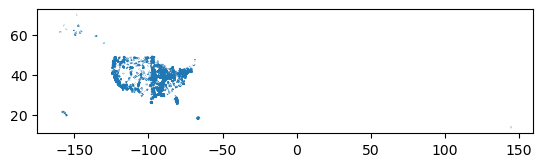

In [17]:
levees_data.iloc[:].plot()

<Axes: >

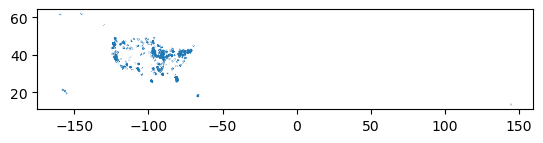

In [18]:
levees_data.iloc[:1000].plot()

In [19]:
# Now get masks for all images:
lidar_images_arr = []
targets_arr = []
for image in images:
    lidar_data, target = get_mask(image, levees_data_26910_full, invert=True)
    lidar_data = lidar_data.reshape(lidar_data.shape[1], lidar_data.shape[2])
    lidar_images_arr.append(lidar_data)
    targets_arr.append(target)

lidar_images_arr = np.array(lidar_images_arr)
targets_arr = np.array(targets_arr)

lidar_images_arr.shape

(7, 10012, 10012)

0


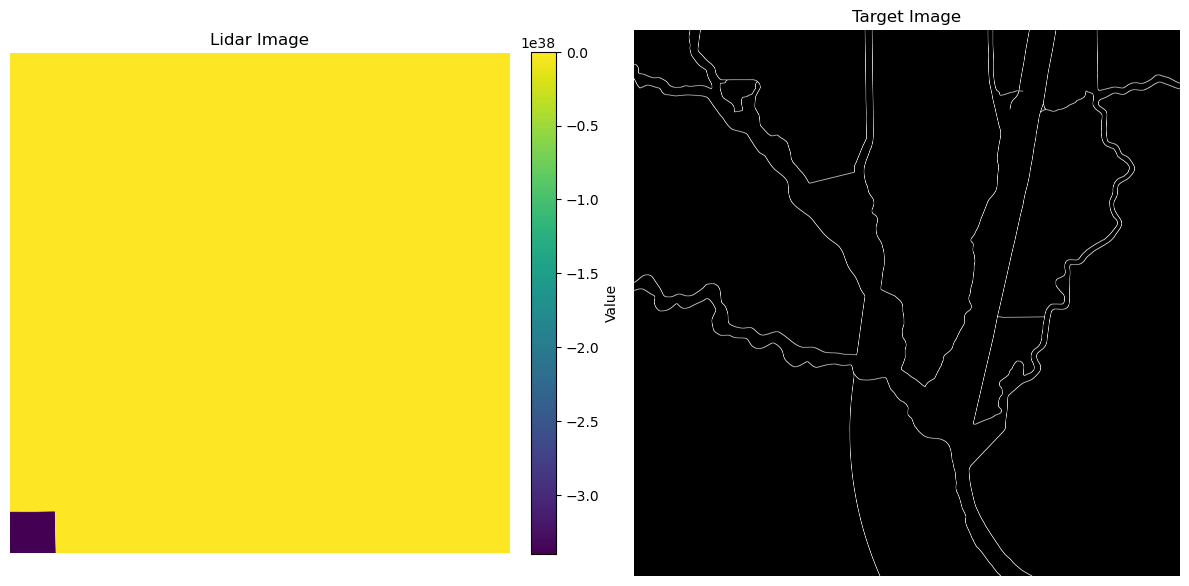

1


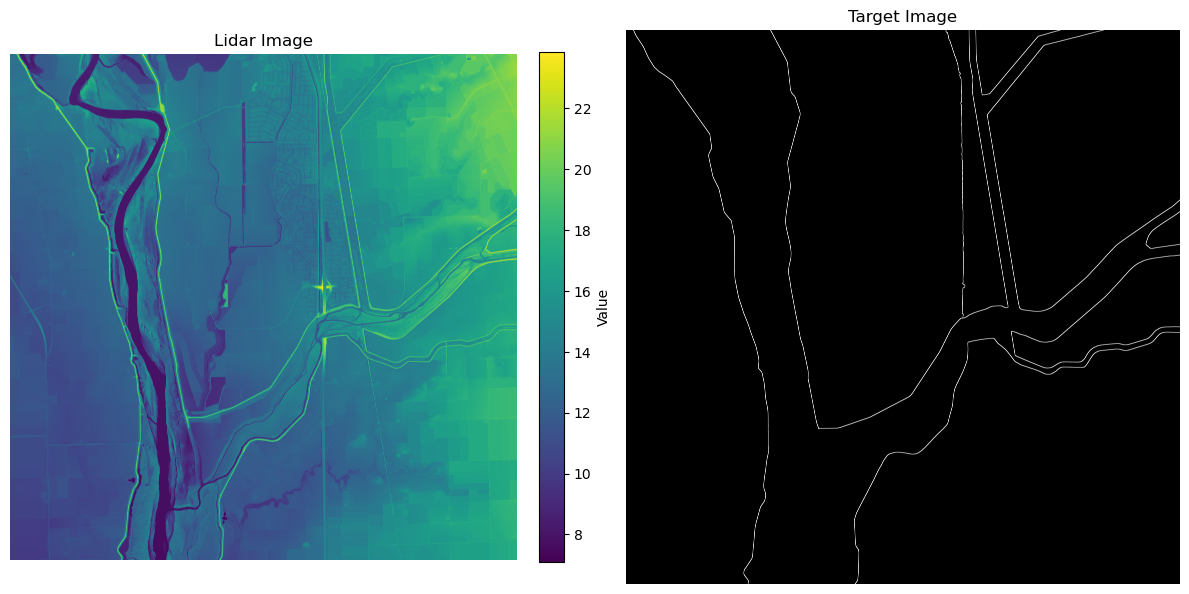

2


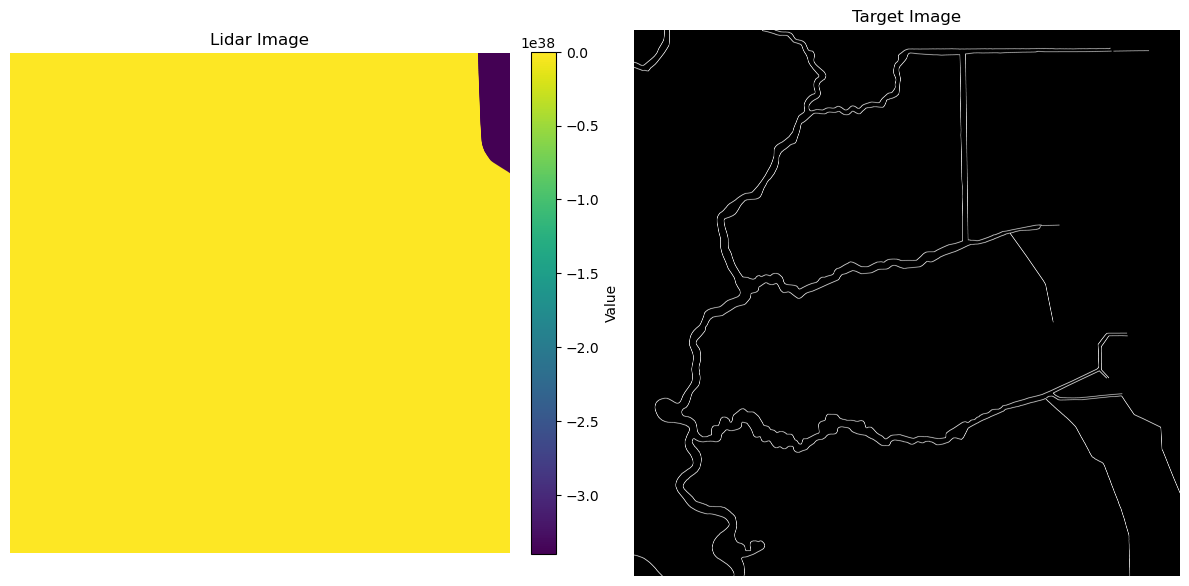

3


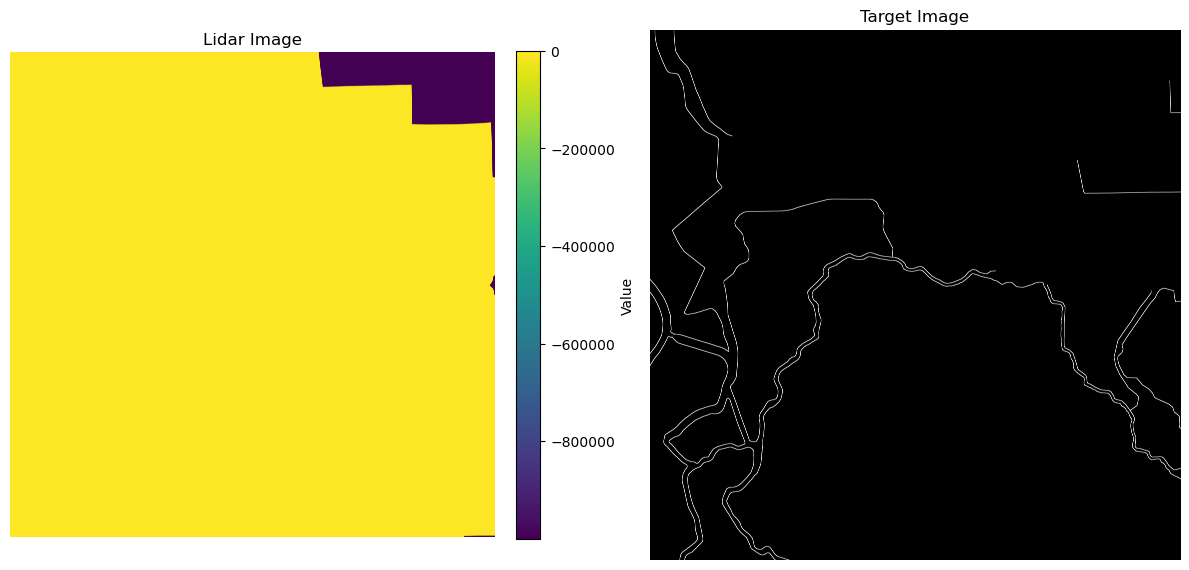

4


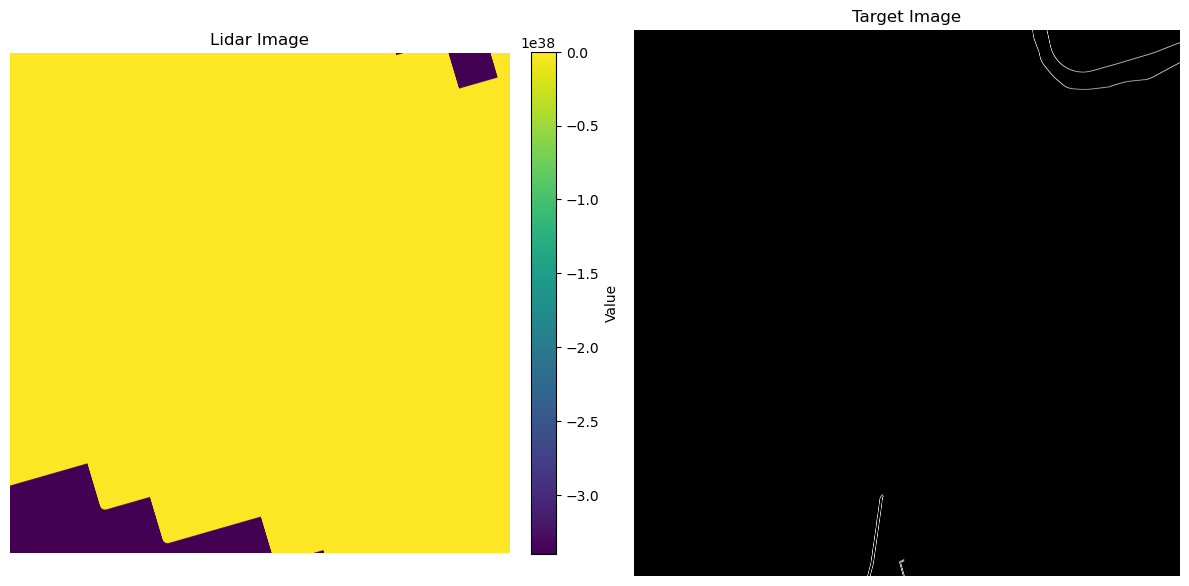

5


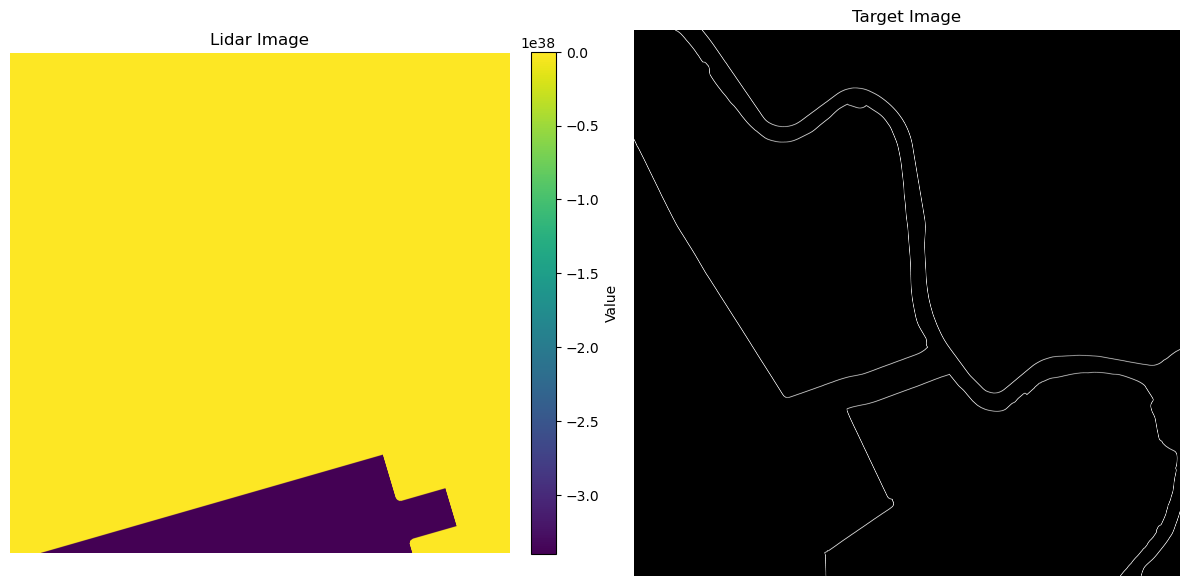

6


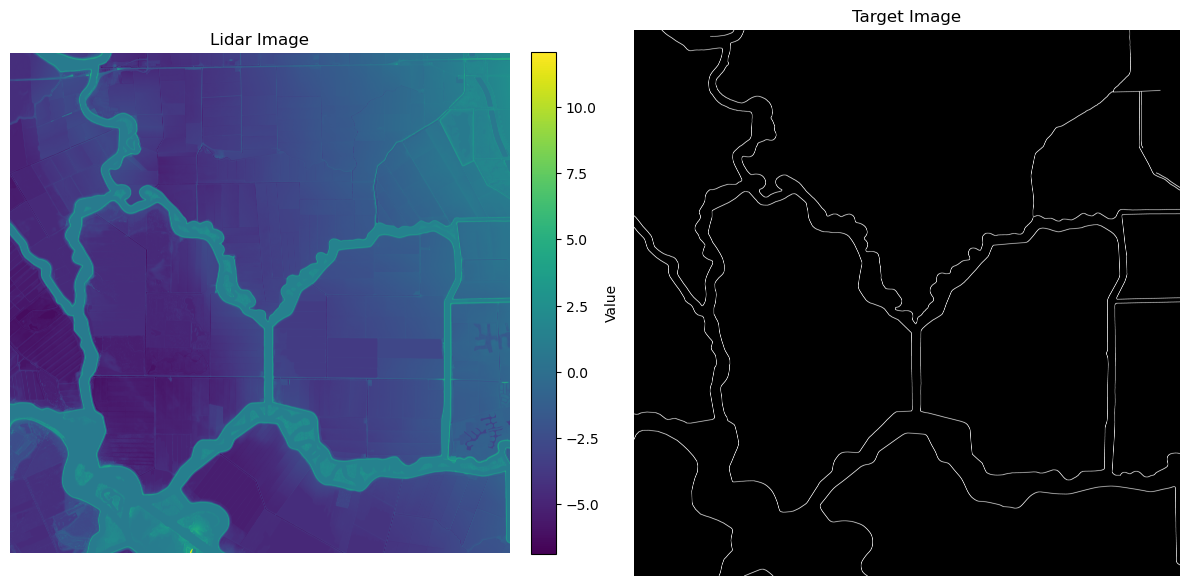

In [20]:
for ix in range(len(lidar_images_arr)):
    print(ix)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

    # Plot the first image
    im = axes[0].imshow(lidar_images_arr[ix], cmap="viridis")
    axes[0].set_title("Lidar Image")
    axes[0].axis("off")

    cbar = fig.colorbar(
        im, ax=axes[0], orientation="vertical", fraction=0.046, pad=0.04
    )
    cbar.set_label("Value")  # Optional: Label for the colorbar

    # Plot the second image
    axes[1].imshow(
        targets_arr[ix], cmap=ListedColormap(["white", "black"]), vmin=0, vmax=1
    )  # Explicitly map 0->white, 1->black
    axes[1].set_title("Target Image")
    axes[1].axis("off")  # Hide axes for cleaner visualization

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [21]:
lidar_images_arr.shape, targets_arr.shape

((7, 10012, 10012), (7, 10012, 10012))

In [22]:
find_splits(Z=10012, s=2560, max_overlap_frac=0.1)[:5]

[(4, 76, 10012),
 (4, 77, 10009),
 (4, 78, 10006),
 (4, 79, 10003),
 (4, 80, 10000)]

In [23]:
find_splits(Z=10012, s=512, max_overlap_frac=0.1)[:5]

[(20, 12, 10012),
 (21, 37, 10012),
 (20, 13, 9993),
 (21, 38, 9992),
 (20, 14, 9974)]

In [24]:
img_1m_dataset = SegmentationDataset(
    images=lidar_images_arr,
    targets=targets_arr,
    transform=None,
    split=True,
    patch_size=512,
    final_size=512,
    overlap=12,
)

len(img_1m_dataset)  # 400 x 7

2800

In [25]:
img_1m_dataset.remove_invalid_images()
len(img_1m_dataset)

2677

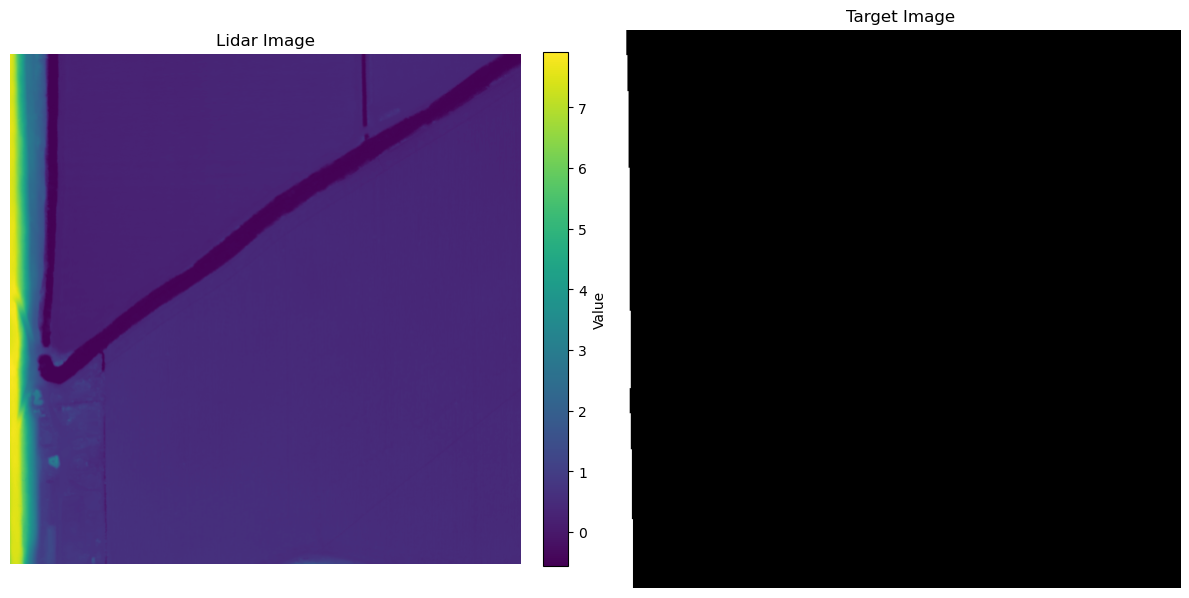

In [26]:
img_1m_dataset.plot(37, figsize=(12, 6))

In [27]:
img_1m_dataset.remove_empty(keep_empty=0.2)
len(img_1m_dataset)

993

In [28]:
selected, special = interactive_labeling(img_1m_dataset)

Label(value='')

Output()

Button(description='Yes (y)', style=ButtonStyle())

Button(description='Special (s)', style=ButtonStyle())

Button(description='No (n)', style=ButtonStyle())

Button(description='Quit (q)', style=ButtonStyle())

In [31]:
len(selected)

881

In [32]:
len(special)

700

In [33]:
# Convert selected indices to a set for efficient lookup
selected_set = set(selected)

# Find all indices that were NOT selected
all_indices = set(range(len(img_1m_dataset.images)))
bad_indices = list(all_indices - selected_set)  # Get unselected indices

# Extract images and targets
good_imgs = np.array([img_1m_dataset.images[i] for i in selected])
good_targets = np.array([img_1m_dataset.targets[i] for i in selected])

special_imgs = np.array([img_1m_dataset.images[i] for i in special])
special_targets = np.array([img_1m_dataset.targets[i] for i in special])

bad_imgs = np.array([img_1m_dataset.images[i] for i in bad_indices])
bad_targets = np.array([img_1m_dataset.targets[i] for i in bad_indices])

good_imgs.shape, good_targets.shape

((881, 1, 512, 512), (881, 1, 512, 512))

In [41]:
# Define weights (higher for special images)
weights = torch.ones(len(good_imgs))  # Default weight = 1
special_indices_set = set(special)  # Convert to set for fast lookup

# Assign higher weight (e.g., 2x) to special images
for i, idx in enumerate(selected):
    if idx in special_indices_set:
        weights[i] = 2.0  # Increase weight

In [42]:
weights

tensor([1., 2., 2., 1., 1., 2., 2., 1., 2., 2., 2., 2., 2., 1., 2., 2., 1., 2.,
        2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1.,
        2., 2., 2., 2., 1., 2., 2., 2., 2., 1., 2., 2., 2., 1., 1., 2., 2., 2.,
        2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1.,
        2., 2., 2., 1., 1., 2., 2., 2., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 1., 2., 2.,
        2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 1., 1., 2., 2., 2., 1., 1.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2.,
        2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2.,
        1., 2., 2., 2., 2., 2., 2., 2., 

In [44]:
selected[:10]

[0, 1, 2, 3, 4, 6, 7, 8, 9, 10]

In [45]:
special[:10]

[1, 2, 6, 7, 9, 10, 11, 12, 14, 16]

In [46]:
torch.save(weights, "../data/raw/w4-Lidar/1m_resolution/weights_512.pt")

print("Weights saved to weights.pt")

Weights saved to weights.pt


In [34]:
good_dataset = SegmentationDataset(
    images=good_imgs, targets=good_targets, transform=None, split=False
)

len(good_dataset)

881

In [35]:
better_dataset = SegmentationDataset(
    images=special_imgs, targets=special_targets, transform=None, split=False
)

len(better_dataset)

700

In [36]:
bad_dataset = SegmentationDataset(images=bad_imgs, targets=bad_targets, transform=None)

len(bad_dataset)

112

In [37]:
torch.save(
    good_dataset, "../data/processed/w3-4-based-datasets/good_dataset_1m_512.pth"
)
torch.save(
    better_dataset, "../data/processed/w3-4-based-datasets/better_dataset_1m_512.pth"
)
torch.save(bad_dataset, "../data/processed/w3-4-based-datasets/bad_dataset_1m_512.pth")